In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import zipfile
from torchvision.datasets import ImageFolder

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
zip_path = '/content/archive.zip'
extract_path = ''

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

img_size = 164
transform = transforms.Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor()])

path = '/content/Alzheimer_s Dataset'

dataset = ImageFolder(path + '/train', transform=transform)
print('Size of training dataset :', len(dataset))

test = ImageFolder(path + '/test', transform=transform)
print('Size of test dataset :', len(test))

Size of training dataset : 5121
Size of test dataset : 1279


In [6]:
classes = ('MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented')

In [7]:
batch_size = 4
train_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

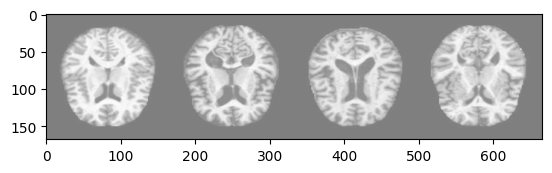

NonDemented MildDemented MildDemented NonDemented


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



dataiter = iter(train_dl)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 20 * 20, 512)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 4)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, 64 * 20 * 20)
        x = self.relu_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(20):

    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 1.081
[1,   400] loss: 1.004
[1,   600] loss: 1.072
[1,   800] loss: 1.050
[1,  1000] loss: 1.013
[1,  1200] loss: 1.052
[2,   200] loss: 1.020
[2,   400] loss: 0.943
[2,   600] loss: 0.982
[2,   800] loss: 0.948
[2,  1000] loss: 0.993
[2,  1200] loss: 0.921
[3,   200] loss: 0.952
[3,   400] loss: 0.902
[3,   600] loss: 0.878
[3,   800] loss: 0.878
[3,  1000] loss: 0.872
[3,  1200] loss: 0.856
[4,   200] loss: 0.842
[4,   400] loss: 0.834
[4,   600] loss: 0.767
[4,   800] loss: 0.780
[4,  1000] loss: 0.786
[4,  1200] loss: 0.766
[5,   200] loss: 0.723
[5,   400] loss: 0.679
[5,   600] loss: 0.686
[5,   800] loss: 0.680
[5,  1000] loss: 0.635
[5,  1200] loss: 0.672
[6,   200] loss: 0.602
[6,   400] loss: 0.557
[6,   600] loss: 0.517
[6,   800] loss: 0.434
[6,  1000] loss: 0.481
[6,  1200] loss: 0.416
[7,   200] loss: 0.364
[7,   400] loss: 0.349
[7,   600] loss: 0.306
[7,   800] loss: 0.336
[7,  1000] loss: 0.258
[7,  1200] loss: 0.219
[8,   200] loss: 0.209
[8,   400] 

KeyboardInterrupt: 

In [13]:
PATH = './dementia.pth'
torch.save(net.state_dict(), PATH)

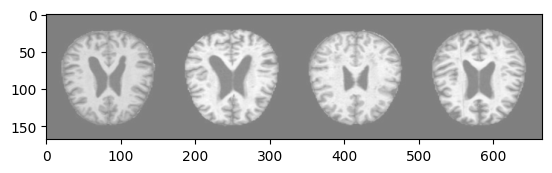

GroundTruth:  NonDemented MildDemented NonDemented VeryMildDemented


In [14]:
dataiter = iter(test_dl)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [15]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  NonDemented MildDemented VeryMildDemented VeryMildDemented


In [17]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: MildDemented is 34.6 %
Accuracy for class: ModerateDemented is 25.0 %
Accuracy for class: NonDemented is 47.2 %
Accuracy for class: VeryMildDemented is 83.9 %


['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']


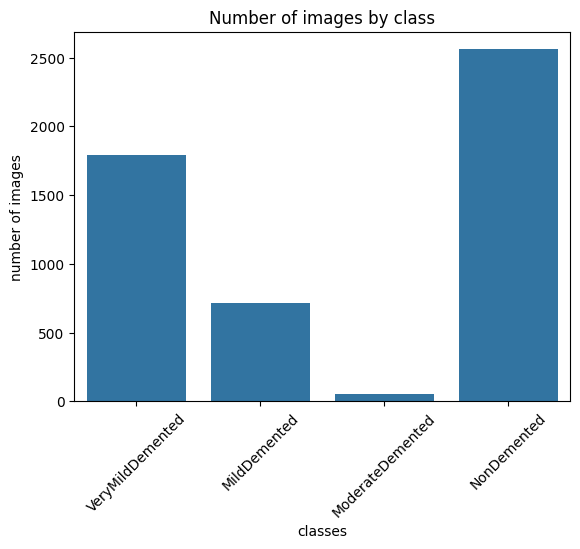

In [34]:
import os
import seaborn as sns
path = 'Alzheimer_s Dataset/train'

objects_all = os.listdir(path)
objects = [x for x in objects_all if x != '.DS_Store']

images = []

for item in objects:
  number_of_images = len(os.listdir(path + '/' + item))
  images.append(number_of_images)

sns.barplot(x=objects, y=images)
plt.xlabel('classes')
plt.ylabel('number of images')
plt.title('Number of images by class')
plt.xticks(rotation=45)
plt.show()

Був використаний датасет МРТ знімків мозку для виявлення різного ступеня хвороби Альцгеймера. CNN скаладається з 3 блоків операції згортки, нелінійної функції (ReLU) активації та макс пулу. В кінечному етапі було використано два fully connected шари для класифікації 4 класів. Отримані результати напряму пов'язані з кількостю даних для тренування, що викликало **труднощі** протягом тренування. Так, найменш точними передбачення є у класах MildDemented & ModerateDemented, що містять найменшу кількість даних. Як варіант вирішення - аугментація даних.